# Generating data based on extracted positional data from Ant recordings

Assuming a numpy array is provided from some ant-tracking library/software, then we can read in the ant position time series. From this time series data, we can generate per-ant training data by slicing up "interesting" ant dynamics over a period of time.


In [1]:
# Imports
import numpy as np
import lzma, pickle

from collections import namedtuple

# Plotting/output
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_theme()

sns.set_style(style='white')

# ---------------------------

# Progress bar
from IPython.display import HTML, display
import time

def ProgressIter(iter_fun, iter_len=0):
  if not iter_len:
    iter_len = len(iter_fun)
  out = display(progress(0, iter_len), display_id=True)
  for i, it in enumerate(iter_fun):
    yield it
    out.update(progress(i + 1, iter_len))

def progress(value, max):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 45%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

## Loading the data

The file format is as follows:
- 64 ants
- the files is numpy array format and the shape is (526200, 64, 2) = (time frame, N, x-y)
- FPS is 59.94

- Arena width = 100 mm ~= 856 px
- 5 mm ~= 43 px
- 

In [2]:
file_name = "../../data/N064_01_JDJ_20211014_position_filled.npy"
data = np.load(file_name)
# data = data[:round(len(data)/2)] # Maruyama-san says the second half is boring.

Ants = namedtuple('Ants', ['pos', 'traj', 'kinergy'])

colony_size = len(data[0])
time = len(data)
interval = 60   # Process every [interval] frames to generate future data
unit_conversion = 43/5  # Pixel-to-mm conversion

# Create a named tuple for the ants which stores position, colour and cluster.
# Useful data can be added to this type at a later date.
ants = Ants(
    pos = np.array(data[0][:]),
    traj = np.array([[np.NaN, np.NaN] for _ in range(colony_size)]),
    kinergy = np.array([np.NaN for _ in range(colony_size)]),
)

## Data generation

Now that the supporting data structures have been created, we need to fill the time series with data based on the ants' positions captured from the video.

In [3]:
def ant_trajectory(ants, prev_ants):
    return ants - prev_ants

def distances_travelled(distances):
    return [np.sqrt(x.dot(x)) for x in distances]

def kinetic_energy(ants, prev_ants):
    return [np.sum(x.dot(x)) for x in ants - prev_ants]

### Calculate Euclidean distances between each pair of ants, as well as each ant's distance of travel over time

Given the positions of ants at each time step, we need to calculate their respective Euclidean distances. For each pair, we can then use their distance to determine if they are interacting, based on some simple definition of an **interaction**. Similarly, we can use this definition of interaction to determine whether a pair of ants is "connected" in a network.

*(An interaction is currently based on pairwise distance alone, but in the future it would be ideal to be able to identify the angle of each ant to determine a more accurate interaction, and also perhaps classify the kind of interaction observed.)*

In [4]:
def euclidean_distances(ants):
    a = np.array(ants.pos)
    b = a.reshape(a.shape[0], 1, a.shape[1])
    distances = np.sqrt(np.einsum('ijk, ijk->ij', a-b, a-b))
    np.fill_diagonal(distances, np.NaN)
    distances[np.arange(distances.shape[0]) > np.arange(distances.shape[1])[:,None]] = np.NaN

    return distances

In [5]:
ants_buffer = []
travel_dist_buffer = []
pairwise_dist_buffer = []

state = {
    'ants': ants,
    'travel_distances': np.zeros(colony_size, dtype=float),
    'kinetic_energy': np.zeros(colony_size, dtype=float),
    'pairwise_distances': np.zeros((colony_size, colony_size), dtype=float),
}

# approx. 60 frames per second
for i in ProgressIter(range(0, time, interval)):
    state['ants'] = Ants(
        np.array(data[i][:]),
        np.array([[np.NaN, np.NaN] for _ in range(colony_size)]) if i == 0 else ant_trajectory(np.array(data[i][:]), np.array(data[i - interval][:])),
        np.array([np.NaN for _ in range(colony_size)]) if i == 0 else kinetic_energy(np.array(data[i][:]), np.array(data[i - interval][:])),
    )
    state['travel_distances'] = distances_travelled(state['ants'].traj)
    state['pairwise_distances'] = euclidean_distances(state['ants'])

    ants_buffer += [state['ants']]
    travel_dist_buffer += [state['travel_distances']]
    pairwise_dist_buffer += [state['pairwise_distances']]


In [6]:
# Pickle the relevant ant data for other notebooks to use.
import lzma, pickle

with lzma.open('../data/ants_time_series_data.pkl.xz', 'wb') as file:
    pickle.dump(ants_buffer, file)

with lzma.open('../data/ants_travel_distances.pkl.xz', 'wb') as file:
    pickle.dump(travel_dist_buffer, file)

with lzma.open('../data/ants_pairwise_distances.pkl.xz', 'wb') as file:
    pickle.dump(pairwise_dist_buffer, file)

### Ant trajectories

/opt/homebrew/Caskroom/miniforge/base/envs/wannts/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniforge/base/envs/wannts/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniforge/base/envs/wannts/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/wannts/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWar

Text(0.5, 1.0, 'Distance travelled (mm)')

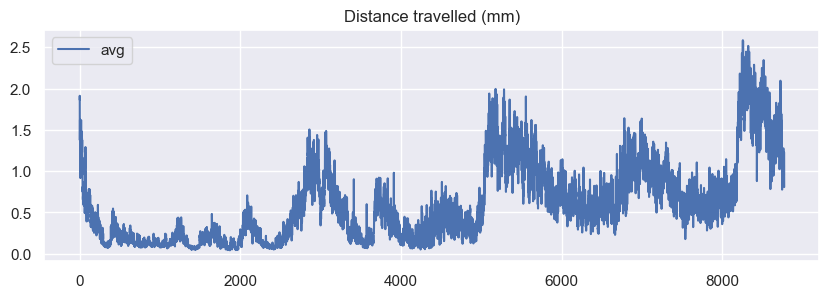

In [7]:
sum_distances_travelled = np.array([np.sum(x) for x in travel_dist_buffer])/unit_conversion
max_distances_travelled = np.array([np.max(x) for x in travel_dist_buffer])/unit_conversion
avg_distances_travelled = np.array([np.average(x) for x in travel_dist_buffer])/unit_conversion
sns.set(rc={'figure.figsize':(10,3)})
plt = sns.lineplot(x=list(range(len(avg_distances_travelled))), y=avg_distances_travelled, label='avg')
plt.set_title('Distance travelled (mm)')